In [1]:
# AYU CODE
from scipy import fft
from qtn.bimax import BiMax
from qtn.util import (boltzmann, emass, echarge, permittivity, cspeed, fperp, fp)
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from pyspedas import wind
from pytplot import tplot, get_data
import pandas as pd
import time
import netCDF4 as nc
%matplotlib inline

In [2]:
ant_len = 50      # m (monopole) 
ant_rad = 1.9e-4  # m
base_cap = 20e-12 # Farad
fbins = np.array([4000*1.0445**i for i in range(96)])

In [3]:
def find_closest_time(time, lst):
    return min(range(len(lst)), key=lambda i: abs(time-lst[i]))

In [4]:
#data = wind.waves(trange=['1995-6-25', '1995-6-26'],get_support_data=True)
ds =  nc.Dataset("data/wi_wav_tnr_19950625.nc")
print(ds)
print(np.size(ds["tnr_ch1_time"][:]))

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): n_times(19419), n_bins(96)
    variables(dimensions): float64 tnr_ch1_time(n_times), float64 tnr_ch1_freq(n_bins), float64 tnr_ch1_spec(n_bins, n_times)
    groups: 
19419


## Plot 1: June 25, 1995 06:33:06.432

### Theoretical

Need to import data for:
vsw: Solar Wind Speed - Solar Wind Experiment(SWE)
tc: core electron temperature
fpe: core electron plasma frequency - 
n: 

In [5]:
vsw=3.966e5
tc = 9.91 * echarge/boltzmann
t = 6.57
n = 0.026
tep = 9.91/9.62
fpe = 31.47e3

In [6]:
ne = 12.28e6
nc = ne/(1+n)
ldc = np.sqrt(permittivity * boltzmann * tc/ nc / echarge**2)
lrel = ant_len/ldc

In [7]:
p = BiMax(ant_len, ant_rad, base_cap)

In [8]:
wrelplot = fbins/fpe

In [9]:
g_s = np.array([p.gamma_shot(wrel, lrel, n, t, tc) for wrel in wrelplot])

In [10]:
def helper(wrel):
    """
    add precision control to bimax function.
    
    """
    if wrel > 1 and wrel < 1.2:
        mp.mp.dps = 40
    else:
        mp.mp.dps = 20
    return p.bimax(wrel, lrel, n, t, tc)

In [11]:
enoise = np.array([helper(wrel) for wrel in wrelplot])

In [12]:
#Modified by AYU 
# - Was running into an parameter error 
# - need to fix to match up with reference graph
#pnoise = np.array([p.proton(wrel*np.sqrt(1+n), ne, n, t, tep, tc, vsw) for wrel in wrelplot])
pnoise = np.array([p.proton2(wrel*np.sqrt(1+n), lrel, tep, tc, vsw) for wrel in wrelplot])

In [13]:
gamma = g_s[:, 0]
shot = g_s[:, 1]
vr2 = enoise + pnoise + shot

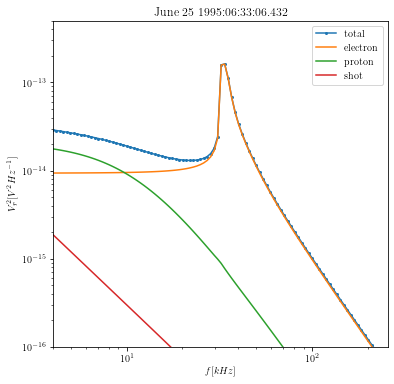

In [14]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=[6, 6])
plt.plot(fbins/1000, vr2/gamma, 'o-', markersize=2, label='total')
plt.plot(fbins/1000, enoise/gamma, label='electron')
plt.plot(fbins/1000, pnoise/gamma, label='proton')
plt.plot(fbins/1000, shot/gamma, label='shot')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4, 256])
plt.ylim([1e-16, 5e-13])
plt.xlabel(r'$f[kHz]$')
plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
plt.title('June 25 1995:06:33:06.432')
plt.legend(loc='best')
plt.show()

In [15]:
fig.savefig('Plots/wind19950625_theoretical.png', dpi=300)

### Experimental

#m_dat=readsav('/Users/Tong/Google Drive/research/data/meudon_tnr/TNR_XY_ACE_19950625.sav')
#data = wind.waves(trange=['1995-6-25', '1995-6-26'],get_support_data=True)


#tplot(['E_VOLTAGE_TNR'])

# Here I imported the Voltage TNR data and tried to find the epoch time
# Converting 
export_data = get_data('E_VOLTAGE_TNR')
min_data = get_data('Minimum_voltage_TNR')
df = pd.DataFrame(export_data.y)
#df.describe()
loc = min(range(len(export_data.times)), key=lambda i: abs(804061986.432-export_data.times[i]))
#print(np.shape(export_data.y))
#print(export_data.times[loc], loc)
#print("TARGET TIME: "+str(time.strftime("%d %b %Y %H:%M:%S", time.gmtime(804061986))))

#print("Closest times to Target Time")
#print(str(time.strftime("%d %b %Y %H:%M:%S", time.gmtime(export_data.times[loc-1]))))
print(str(time.strftime("%d %b %Y %H:%M:%S", time.gmtime(export_data.times[loc]))))
#print(str(time.strftime("%d %b %Y %H:%M:%S", time.gmtime(export_data.times[loc+1]))))

oldTime = export_data.times[0]-60
for time in export_data.times:
    if oldTime + 60 != time:
        print(time)
    oldTime = time

data = wind.waves(trange=['1995-6-25', '1995-6-26'],get_support_data=True)

In [16]:
string = """-130.124 -131.359 -132.755 -134.210 -135.386 -136.499 -137.461 -138.111
 -138.560 -138.697 -139.057 -139.141 -139.279 -139.415 -139.462 -139.769
 -139.686 -139.964 -140.331 -140.741 -140.971 -141.090 -141.485 -141.904
 -142.199 -142.432 -142.835 -143.315 -143.951 -144.490 -145.242 -146.096
 -148.075 -148.554 -149.031 -149.393 -149.864 -150.162 -150.550 -150.919
 -151.406 -151.835 -152.209 -152.690 -153.167 -153.531 -152.790 -152.539
 -153.934 -154.355 -154.585 -154.704 -154.938 -155.145 -155.330 -155.495
 -155.808 -156.006 -156.193 -156.279 -156.423 -156.356 -156.243 -156.101
 -156.739 -156.883 -157.240 -157.343 -157.367 -157.680 -157.756 -157.461
 -157.421 -158.109 -153.938 -155.412 -157.632 -158.470 -157.843 -157.209
 -158.312 -158.744 -159.215 -158.993 -158.936 -159.120 -159.320 -159.747
 -159.752 -159.640 -156.215 -156.530 -157.592 -159.019 -157.112 -156.001"""
lst = string.split(" ")
lst = [float(num) for num in lst]
print([10**(num/10) for num in lst])

[9.7185170294017e-14, 7.313074538624811e-14, 5.302735926292154e-14, 3.793149849736809e-14, 2.89334352339151e-14, 2.2392366825123616e-14, 1.794320421716837e-14, 1.5448986725154426e-14, 1.3931568029453036e-14, 1.3498950350559801e-14, 1.2425103069290103e-14, 1.2187089485092812e-14, 1.1805924458138925e-14, 1.1441948798169872e-14, 1.131878993655418e-14, 1.0546297058996503e-14, 1.0749790488200815e-14, 1.0083237577615525e-14, 9.26616437493746e-15, 8.431405951147685e-15, 7.996501075653532e-15, 7.78036551039804e-15, 7.1039517000295234e-15, 6.450598332848311e-15, 6.0269834652118385e-15, 5.712155216230454e-15, 5.205950088015483e-15, 4.66122428001887e-15, 4.026243159764705e-15, 3.55631318568984e-15, 2.9908869650638324e-15, 2.4569708276368362e-15, 1.557758034831605e-15, 1.3950828503573704e-15, 1.2499711805783696e-15, 1.1500057186992375e-15, 1.0318106352675928e-15, 9.63385266142348e-16, 8.81048873008011e-16, 8.092822218443724e-16, 7.234358058506338e-16, 6.553902858334767e-16, 6.013121787899332e-16, 

Target Time: 25 Jun 1995 06:33:06
Time Found: 25 Jun 1995 06:33:08.6399999856948853
(96,)


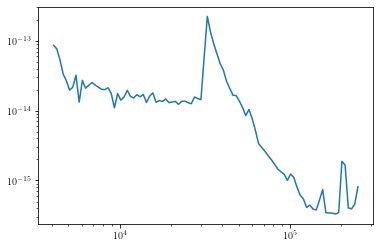

In [17]:
#export_data = get_data('E_VOLTAGE_TNR')
#min_data = get_data('Minimum_voltage_TNR')

#loc = min(range(len(export_data.times)), key=lambda i: abs(804061986.432-export_data.times[i]))
#spec = export_data.y[loc][:]
#min_spec = min_data.y[0][:]
#freq = export_data.v

loc = find_closest_time(804061986.432, ds["tnr_ch1_time"])
print(f"Target Time: {time.strftime('%d %b %Y %H:%M:%S', time.gmtime(804061986.432))}")
print(f"Time Found: {time.strftime('%d %b %Y %H:%M:%S', time.gmtime(int(ds['tnr_ch1_time'][loc])))}{str(ds['tnr_ch1_time'][loc]%1)[1:]}")
spec = ds["tnr_ch1_spec"][:, loc][:]
freq = ds["tnr_ch1_freq"][:]
#print(spec)

spec /= 1e6

#spec = np.multiply(spec,min_spec)

spec = spec**2
spec -= [10**(num/10) for num in lst]

print(np.shape(spec))

plt.plot(freq, spec)
plt.xscale('log')
plt.yscale('log')
plt.show()

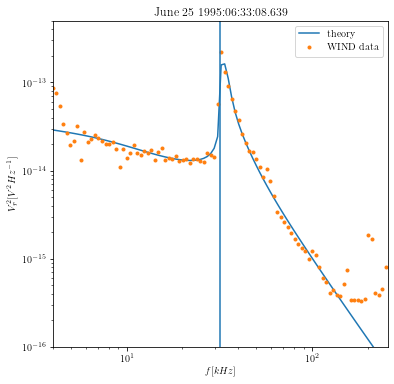

In [18]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=[6, 6], facecolor="white")
plt.plot(fbins/1000, vr2/gamma, label='theory')
#plt.plot(fbins/1000, enoise/gamma, label='electron')
#plt.plot(fbins/1000, pnoise/gamma, label='proton')
#plt.plot(fbins/1000, shot/gamma, label='shot')
plt.plot(fbins/1000, spec, 'o', markersize=3, label='WIND data')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4, 256])
plt.ylim([1e-16, 5e-13])
plt.xlabel(r'$f[kHz]$')
plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
plt.title('June 25 1995:06:33:08.639')
#plt.title('June 25 1995:06:33:06.432')
plt.legend(loc='best')
plt.axvline(x=31.924165899128376)
plt.show()
fig.savefig('Plots/wind19950625.png', dpi=300)

## Plot 2: June 25, 1995 18:52:34.344 GMT

In [19]:
assert False

AssertionError: 

### Theoretical

In [20]:
vsw=7.61e5
tc = 11.53 * echarge/boltzmann
t = 5.57
n = 0.059
tep = 11.53/47.49
fpe = 22.24e3
te = tc * (1 + n)/(1 + n/t)
print(te)
te = te

140209.15454394044


In [21]:
ne = 6.13e6
nc = ne/(1+n)
ldc = np.sqrt(permittivity * boltzmann * tc/ nc / echarge**2)
lc = ant_len/ldc
print(lc)
lde = np.sqrt(permittivity * boltzmann * te/ ne / echarge**2)
le = ant_len/lde
print(le)

4.765609260851047
4.790782536518215


In [22]:
p = BiMax(ant_len, ant_rad, base_cap)

In [23]:
wrelplot = fbins/fpe

In [24]:
#wrelplot = wrelplot[0:2]

In [25]:
g_s = np.array([p.gamma_shot(wrel, lrel, n, t, tc) for wrel in wrelplot])

In [26]:
wrelplot[0]

0.17985611510791366

In [27]:
wrel = wrelplot[0]
print(p.gamma_shot(wrel, lrel, n, t, tc))
print(p.proton2(wrel, lc, tep, tc, vsw))
print(p.proton2(wrel, le, tep, te, vsw))

[mpf('1.3209226513215182'), mpf('1.3306412546792218e-15')]
2.7102680810816977e-14
2.817464386296281e-14


In [28]:
p.proton2(0.1, le, tep, te, vsw)

3.067830642225273e-14

In [29]:
def helper(wrel):
    """
    add precision control to bimax function.
    
    """
    if wrel > 1 and wrel < 1.2:
        mp.mp.dps = 40
    else:
        mp.mp.dps = 20
    return p.bimax(wrel, lrel, n, t, tc)

In [30]:
enoise = np.array([helper(wrel) for wrel in wrelplot])

In [31]:
pnoise = np.array([p.proton2(wrel*np.sqrt(1+n), lrel, tep, tc, vsw) for wrel in wrelplot])

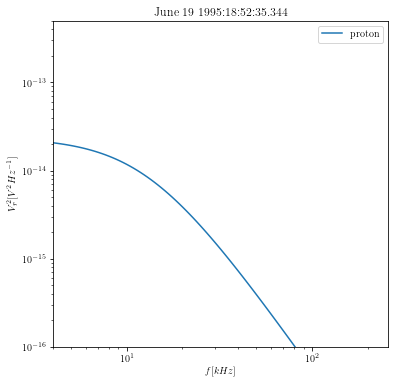

In [32]:
fig = plt.figure(figsize=[6, 6])
plt.plot(fbins/1000, pnoise, label='proton')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4, 256])
plt.ylim([1e-16, 5e-13])
plt.xlabel(r'$f[kHz]$')
plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
plt.title('June 19 1995:18:52:35.344')
plt.legend(loc='best')
plt.show()

In [33]:
gamma = g_s[:, 0]
shot = g_s[:, 1]
vr2 = enoise + pnoise + shot

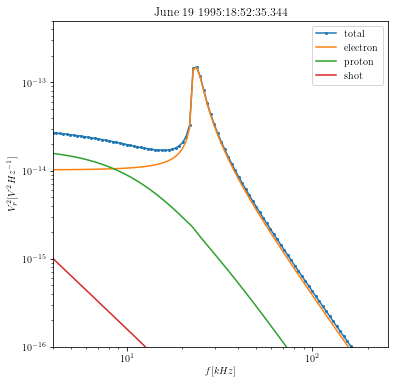

In [34]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=[6, 6])
plt.plot(fbins/1000, vr2/gamma, 'o-', markersize=2, label='total')
plt.plot(fbins/1000, enoise/gamma, label='electron')
plt.plot(fbins/1000, pnoise/gamma, label='proton')
plt.plot(fbins/1000, shot/gamma, label='shot')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4, 256])
plt.ylim([1e-16, 5e-13])
plt.xlabel(r'$f[kHz]$')
plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
plt.title('June 19 1995:18:52:35.344')
plt.legend(loc='best')
plt.show()

In [35]:
fig.savefig('Plots/wind19950619_theoretical.png', dpi=300)

### Experimental

In [ ]:
#m_dat=readsav('/Users/Tong/Google Drive/research/data/meudon_tnr/TNR_XY_ACE_19950619.sav')
#export_data = get_data('E_VOLTAGE_TNR')
#min_data = get_data('Minimum_voltage_TNR')

#loc = min(range(len(export_data.times)), key=lambda i: abs(804106352.344-export_data.times[i]))

#spec = export_data.y[loc][:]
#min_spec = min_data.y[0][:]
#freq = export_data.v

loc = find_closest_time(804106352.344, ds["tnr_ch1_time"][:])-1
print(f"Target Time: {time.strftime('%d %b %Y %H:%M:%S', time.gmtime(804061986.432))}")
print(f"Time Found: {time.strftime('%d %b %Y %H:%M:%S', time.gmtime(int(ds['tnr_ch1_time'][loc])))}{str(ds['tnr_ch1_time'][loc]%1)[1:]}")
spec = ds["tnr_ch1_spec"][:, loc][:]
freq = ds["tnr_ch1_freq"][:]
#spec = 10. ** (spec/10.)
spec /= 1e6

#spec = np.multiply(spec,min_spec)

spec = spec**2

plt.plot(freq, spec)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=[6, 6], facecolor="white")
plt.plot(fbins/1000, vr2/gamma, label='theory')
#plt.plot(fbins/1000, enoise/gamma, label='electron')
#plt.plot(fbins/1000, pnoise/gamma, label='proton')
#plt.plot(fbins/1000, shot/gamma, label='shot')
plt.plot(fbins/1000 * 1.02, spec, 'o', markersize=2, label='WIND data')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4, 256])
plt.ylim([1e-18, 1e-10])
plt.xlabel(r'$f[kHz]$')
plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
plt.title('19-JUN-1995, 18:52:32.400')
plt.legend(loc='best')
plt.show()

In [ ]:
fig.savefig('Plots/wind19950619.png', dpi=300)